# Wind Farm Test
In this file, one can test certain wind farm layouts and configurations. Some basic functions are demonstrated. With the resulting turbine power outputs and flowfields, one can make their own comparisons between farms.

### Import libraries
Here, the libraries used in this file are imported.

In [125]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import time
import copy
import os
from IPython.display import display, clear_output
from scipy import optimize
from scipy.stats import truncnorm
from itertools import product

# Import custom libraries
import functions as func
import visualization as viz

# Import models
from floris.tools import FlorisInterface as floris

colors = ['#F79123', '#014043', '#059589', '#19F7E2']

In [2]:
class LES:
    '''
    This class provides tools for handling data obtained with Large Eddy Simulations.
    The output of functions in this class is standardized, so data structures are
    equal between different datasources.
    '''
    def __init__(
        self,
    ):
        pass


    # Get flowfield dataframe
    def get_df_flowfield(
        case_name: str = None,
        location: str = '../LES/',
    ):
        '''
        Get the flowfield dataframe of a LES case.

        Args:
            case_name (str): the name of the case
            location (str): the path to the LES data

        Returns:
            DataFrame: dataframe containing the flowfield data
        '''
        df_flowfield = pd.read_csv(location + case_name + '/' + case_name + '.csv')

        return df_flowfield
    

    def get_gridpoints(
        df_flowfield,    
    ):
        '''
        Get the gridpoints of the LES data

        Args:
            df_flowfield (DataFrame): dataframe containing LES flowfield

        Returns:
            tuple: respectivily the ndarrays of X, Y and Z gridpoints
        '''
        X = np.array(sorted(df_flowfield['Points:0'].unique()))
        Y = np.array(sorted(df_flowfield['Points:1'].unique()))
        Z = np.array(sorted(df_flowfield['Points:2'].unique()))
        
        return X, Y, Z
    

    def get_ABL_params(
        self,
        case_name: str = '1TURB_wd270_ws10_1x_y0_t5',
        location: str = '../LES/',
        z_ref_guess: float = 100,
        U_ref_guess: float = 10,
        alpha_guess: float = 0.12,
    ):  
        '''
        Get the fitted parameters that describe the Atmospheric Boundary
        Layer (ABL) as close as possible below 600m.

        Args:
            case_name (str): the name of the case
            location (str): the path to the LES data
            z_ref_guess (float): initial guess for reference height
            U_ref_guess (float): initial guess for reference velocity
            alpha_guess (float): initial guess for alpha

        Returns:
            dict: containing two arrays with fitted values describing the ABL
        '''
        # Get flowfield
        df_flowfield = self.get_df_flowfield(
            case_name,
            location,
        )

        # Get LES grid points
        X, Y, Z = self.get_gridpoints(df_flowfield)

        # Get U and V profiles of LES simulation at inflow boundary (X = 0)
        U_LES = df_flowfield[df_flowfield['Points:0'] == 0].groupby(['Points:2'])['UAvg:0'].mean().to_numpy()
        V_LES =  df_flowfield[df_flowfield['Points:0'] == 0].groupby(['Points:2'])['UAvg:1'].mean().to_numpy()

        # Get id of points at Z = 600, right before inversion layer starts
        idz, z_value = func.find_nearest(Z, 600)

        # Get U and V profiles from just above Z = 0 to Z = 600, before inversion layer
        cut_start = 2
        Z_cut = Z[cut_start:idz+1]
        U_LES_cut = U_LES[cut_start:idz+1]
        V_LES_cut = V_LES[cut_start:idz+1]

        # Fit streamwise velocity profile parameters
        U_params, _ = sc.optimize.curve_fit(
            func.U_profile, 
            Z_cut, 
            U_LES_cut, 
            p0=[z_ref_guess, U_ref_guess, alpha_guess], 
            bounds=([1, 1, 1e-6], [1e6, 1e6, 1])
        )

        # Fit spanwise velocity profile parameters
        V_params, _ = sc.optimize.curve_fit(
            func.V_profile, 
            Z_cut, 
            V_LES_cut
        )

        return {
            'U_params': U_params,
            'V_params': V_params,
        }


class CCM:
    def __init__(
        self,
        model_params: dict = None,
        input_file: str = 'model_files/CCM/case_initial.yaml',
    ):
        self.input_file = input_file

        if model_params == None:
            model_params = {
                'ad': 0,
                'bd': -0.0018192983887298023,
                'cd': 1.0803331806986867,
                'dd': -0.09040629347972164,
                'alpha': 0.58,
                'beta': 0.077,
                'dm': 1.0,
                'c_s1': 0.0563691592,
                'c_s2': 0.1376631233159683,
                'a_s': 0.3253111149080571,
                'b_s': 0.012031554853652504,
                'a_f': 3.11,
                'b_f': -0.68,
                'c_f': 2.223295807654856,
                'wr_gain': 0.5392489436318193,
                'ma_gain': 1.7431079762733077,
                'wr_decay_gain': 3.207532818500954,
                'ma_decay_gain': 1.7832719494462048,
            }

        self.model_params = model_params

        self.farm = floris(self.input_file)

        self.set_model_params(
            self.model_params
        )
        

    def set_model_params(
        self,
        model_params: dict,
    ):
        '''
        Set model parameters to the CCM model.

        Args:
            model_params (dict): dictionary containing the model parameters
        '''
        # Loop over all model parameters
        for key in model_params.keys():
            found = False

            # Check if in 'gaussm' and if so, apply change
            if key in self.farm.floris.wake.wake_deflection_parameters['gaussm'].keys():
                self.farm.floris.wake.wake_deflection_parameters['gaussm'][key] = model_params[key]
                found = True

            # Check if in 'ccm' and if so, apply change
            if key in self.farm.floris.wake.wake_velocity_parameters['ccm'].keys():
                self.farm.floris.wake.wake_velocity_parameters['ccm'][key] = model_params[key]
                found = True
            
            # Print message if parameter is not found
            if not found:
                print(f'Key named "{key}" not found in either model')
    

    # def reinitialize_farm(
    #     self,
    #     farm_config: dict,
    #     model_params: dict = None,
    # ):
    #     # Set model parameters to given or standard parameters
    #     if model_params is None:
    #         model_params = self.model_params
        
    #     # Run twice, since for some reason sometimes things didn't update
    #     # after running is once (TODO?)
    #     for _ in range(2):
    #         # Update farm layout, wind direction and speed
    #         self.farm.reinitialize(
    #             layout_x=farm_config['x_ij'].flatten(), 
    #             layout_y=farm_config['y_ij'].flatten(), 
    #             wind_directions=farm_config['wind_directions'],
    #             wind_speeds=farm_config['wind_speeds'],
    #         )

    #         # Set model parameters
    #         self.set_model_params(model_params)
            
    #         # Set ABL parameters
    #         if farm_config['ABL_params'] is not None:
    #             U_params = farm_config['ABL_params']['U_params']
    #             V_params = farm_config['ABL_params']['V_params']

    #             # Set parameters of streamwise velocity profile
    #             self.farm.floris.flow_field.reference_wind_height = U_params[0]
    #             self.farm.floris.flow_field.wind_speeds = [U_params[1]]
    #             self.farm.floris.flow_field.wind_shear = U_params[2]
                
    #             # Set parameters of spanwise velocity profile
    #             self.farm.floris.flow_field.a = V_params[0]
    #             self.farm.floris.flow_field.b = V_params[1]
    #             self.farm.floris.flow_field.c = V_params[2]
    #             self.farm.floris.flow_field.d = V_params[3]    

    def reinitialize_farm(
        self,
        conditions: dict,
        layout: dict,
        model_params: dict = None,
    ):
        # Set model parameters to given or standard parameters
        if model_params is None:
            model_params = self.model_params
        
        # Run twice, since for some reason sometimes things didn't update
        # after running is once (TODO?)
        for _ in range(2):
            # Update farm layout, wind direction and speed
            self.farm.reinitialize(
                layout_x=layout['x_i'].flatten(), 
                layout_y=layout['y_i'].flatten(), 
                wind_directions=conditions['directions'],
                wind_speeds=conditions['speeds'],
            )

            # Set model parameters
            self.set_model_params(model_params)
            
            # Set ABL parameters
            if conditions['ABL_params'] is not None:
                U_params = conditions['ABL_params']['U_params']
                V_params = conditions['ABL_params']['V_params']

                # Set parameters of streamwise velocity profile
                self.farm.floris.flow_field.reference_wind_height = U_params[0]
                self.farm.floris.flow_field.wind_speeds = [U_params[1]]
                self.farm.floris.flow_field.wind_shear = U_params[2]
                
                # Set parameters of spanwise velocity profile
                self.farm.floris.flow_field.a = V_params[0]
                self.farm.floris.flow_field.b = V_params[1]
                self.farm.floris.flow_field.c = V_params[2]
                self.farm.floris.flow_field.d = V_params[3]    


    def get_turbine_powers(
        self,
        turbines: dict,
    ):  
        # Get yaw and tilt angles flattened and adjust for number of wind conditions
        yaw_angles = turbines['yaw_i']#.flatten()[None, None]
        tilt_angles = turbines['tilt_i']#.flatten()[None, None]

        # Ensure yaw and tilt have right dimensions
        if len(np.shape(yaw_angles)) == 1:
            yaw_angles = yaw_angles[None, None]
        if len(np.shape(tilt_angles)) == 1:
            tilt_angles = tilt_angles[None, None]

        # Create copy of farm so initial farm is not messed up
        farm_copy = self.farm.copy()

        # Calculate wakes
        farm_copy.calculate_wake(
            yaw_angles=yaw_angles,
            tilt_angles=tilt_angles,
        )

        # Get misalignment correction factors. This is not done anymore 
        # in FLORIS itself (TODO?)
        correction_factors = func.get_correction_factor_misalignment(
            yaw_angles,
            tilt_angles,
        )

        # Get total power (need to account for air density and correction factor)
        turbine_powers = farm_copy.get_turbine_powers() * \
            farm_copy.floris.flow_field.air_density * \
            correction_factors

        return turbine_powers


def get_model_class(
    model_name,      
):
    if model_name == 'LES':
        model = LES
    if model_name == 'CCM':
        model = CCM

    return model

In [3]:
def create_layout(
    shape: str = 'rectangular',
    n_x: int = 1,
    n_y: int = 1,
    spacing_x: float = 5,
    spacing_y: float = 5,
    D_rotor: float = 126,
):
    if shape == 'hexagonal':
        # Calculate the vertical and horizontal spacing between hexagon centers
        vertical_spacing = 0.5 * D_rotor * spacing_x
        horizontal_spacing = np.sqrt(3) * D_rotor * spacing_y

        # Lists to store the x and y coordinates of the grid points
        x_i = np.zeros([n_x, n_y])
        y_i = np.zeros([n_x, n_y])

        # Generate the coordinates of the hexagonal grid
        for row in range(n_y):
            for col in range(n_x):
                x = col * horizontal_spacing
                y = row * vertical_spacing

                # Shift every other row horizontally by half the spacing
                if row % 2 == 1:
                    x += horizontal_spacing / 2
                
                x_i[col, row] = x
                y_i[col, row] = y
    else:
        x_i, y_i = np.meshgrid(
            D_rotor * spacing_x * np.arange(0, n_x, 1),
            D_rotor * spacing_y * np.arange(0, n_y, 1),
        )

    return x_i, y_i


class Case:
    def __init__(
        self,
        name: str = 'test', 
        model: CCM = CCM(),
        predef_case: dict = {}
    ):  
        # Set name
        self.name = name
        self.model = model
        

    def set_layout(
        self,
        shape: str,
        n_x: int = 1,
        n_y: int = 1,
        spacing_x: int = 5,
        spacing_y: int = 5,
        D_rotor: float = 126,
        x_i: list = None,
        y_i: list = None,
    ):
        # Set layout to predefined layout
        if x_i is not None and y_i is not None:
            print('x_i and y_i set to predefined values')
            n_turbines = len(x_i)
        # Set layout according to specifications
        else: 
            x_i, y_i = create_layout(
                shape,
                n_x,
                n_y,
                spacing_x,
                spacing_y,
                D_rotor,
            )

            n_turbines = n_x * n_y

        self.layout = {
            'shape': shape,
            'n_x': n_x,
            'n_y': n_y,
            'x_i': x_i,
            'y_i': y_i,
            'n_turbines': n_turbines,
        }


    def set_conditions(
        self,
        directions: list = np.array([270.]),
        speeds: list = np.array([10.]),
        TI: list = np.array([0.06]),
        ABL_params: dict = None,
    ):
        if type(directions) == int or type(directions) == float:
            directions = np.array([directions])

        if type(speeds) == int or type(speeds) == float:
            speeds = np.array([speeds])

        self.conditions = {
            'directions': directions,
            'speeds': speeds,
            'TI': TI,
            'ABL_params': ABL_params,
        }


    def set_turbines(
        self,
        yaw_i: list,
        tilt_i: list,
        D_rotor_i: list = None,
        CT_i: list = None,
       
    ):  
        # TODO: Add functionality to set CT and D for individual turbs
        
        if D_rotor_i is None:
            D_rotor_i = np.array(self.layout['n_turbines'] * [126])
        # if len(D_rotor_i) == 1:
        #     D_rotor_i = np.array(self.layout['n_turbines'] * [D_rotor_i[0]])
        # if len(yaw_i) == 1:
        #     yaw_i = np.array(self.layout['n_turbines'] * [yaw_i[0]])
        # if len(tilt_i) == 1:
        #     tilt_i = np.array(self.layout['n_turbines'] * [tilt_i[0]])

        self.turbines = {
            'yaw_i': yaw_i,
            'tilt_i': tilt_i,
            'D_rotor_i': D_rotor_i,
            'CT_i': CT_i,
        }
    
    def run(
        self,
    ):
        self.model.reinitialize_farm(
            conditions=self.conditions,
            layout=self.layout,
        )
        
        self.turbine_powers = self.model.get_turbine_powers(
            turbines=self.turbines,
        )

        return self.turbine_powers


class CaseManager:
    def __init__(
        self,
        name: str = 'Case Manager',
        ref_model = LES,
        ref_data_location: str = '../LES/',
        ref_standard_case: str = '1TURB_wd270_ws10_1x_y0_t5',
    ):
        # Set case manager name
        self.name = name

        # Set reference model, data location and case
        self.ref_model = ref_model
        self.ref_data_location = ref_data_location
        self.standard_ref_case = ref_standard_case

        # Initialize case
        self.cases = {}

        # Get Atmospheric Boundary Layer parameters
        self.standard_ref_ABL_params = ref_model.get_ABL_params(
            ref_model,
            ref_standard_case,
            ref_data_location,
        )

        self.set_case_names()


    def set_case_names(
        self,
    ):
        self.case_names = list(self.cases.keys())


    def get_cases(
        self,
    ):
        return list(self.cases.values())


    def load_csv_cases(
        self,
        location: str = '../TouchWind_Optimization_Framework/',
        file_name: str = 'test_cases.csv',
        masks: dict = {},
    ):
        df_cases = pd.read_csv(location + file_name)

        # Select right cases by applying masks
        for mask in masks:
            df_cases = df_cases[df_cases[mask] == masks[mask]].reset_index(drop=True)

        # Create cases
        for name in df_cases['case_name']:
            case_dict = df_cases[df_cases['case_name'] == name].iloc[0]

            case = Case(name)

            if case_dict['equal']:
                x_i, y_i = create_layout(
                    case_dict['shape'],
                    case_dict['n_x'],
                    case_dict['n_y'],
                    case_dict['spacing_x'],
                    case_dict['spacing_y'],
                    case_dict['D_rotor'],
                )
                x_i = x_i.flatten() + case_dict[f'x_0']
                y_i = y_i.flatten() + case_dict[f'y_0']
                yaw_i = np.ones(len(x_i)) * case_dict[f'yaw_0']
                tilt_i = np.ones(len(x_i)) * case_dict[f'tilt_0']
            else:
                n_turbines = case_dict['n_x'] * case_dict['n_y']
                x_i = np.ones(n_turbines)
                y_i = np.ones(n_turbines)
                yaw_i = np.ones(n_turbines)
                tilt_i = np.ones(n_turbines)

                for turb in range(n_turbines):
                    x_i[turb] = case_dict[f'x_{turb}']
                    y_i[turb] = case_dict[f'y_{turb}']
                    yaw_i[turb] = case_dict[f'yaw_{turb}']
                    tilt_i[turb] = case_dict[f'tilt_{turb}']
            
            # Set Atmospheric Boundary Layer parameters
            if case_dict['load_ABL'] == 'standard':
                ABL_params = self.standard_ref_ABL_params
            elif case_dict['load_ABL'] == 'ref':
                ABL_params = self.ref_model.get_ABL_params(
                    self.ref_model,
                    name,
                    self.ref_data_location,
                )
            else:
                ABL_params = None

            # Set case layout
            case.set_layout(
                shape=case_dict['shape'],
                n_x=case_dict['n_x'],
                n_y=case_dict['n_y'],
                spacing_x=case_dict['spacing_x'],
                spacing_y=case_dict['spacing_y'],
                D_rotor=case_dict['D_rotor'],
                x_i = x_i,
                y_i = y_i,
            )

            # Set case wind conditions
            case.set_conditions(
                directions=[case_dict['wd']],
                speeds=[case_dict['U_ref']],
                ABL_params=ABL_params,
            )

            case.set_turbines(
                yaw_i=yaw_i,
                tilt_i=tilt_i,
                D_rotor_i=case_dict['D_rotor'],
            )

            self.cases[name] = case

        self.set_case_names()

In [4]:
hoi = np.zeros(5)

hoi = hoi[None, None]

np.shape(hoi)

(1, 1, 5)

In [5]:
# Add new case
test_casemanager = CaseManager(
    name='Test Case Manager',
    ref_model=LES,
    ref_data_location='../LES/',
    ref_standard_case='1TURB_wd270_ws10_1x_y0_t5',
)

# Set masks to select cases from csv-file
masks = {
    'test': 1,
    'optimization': 1,
}

# Load csv files
test_casemanager.load_csv_cases(
    location='../TouchWind_Optimization_Framework/',
    file_name='test_cases.csv',
    masks=masks,
)

x_i and y_i set to predefined values
x_i and y_i set to predefined values
x_i and y_i set to predefined values
x_i and y_i set to predefined values


In [6]:
cases = test_casemanager.get_cases()

for c in cases:
    turbine_powers = c.run()

    print(turbine_powers)

[[[3833851.67385933]]]
[[[3816327.47741501 1342181.6755733  3816327.47741501 1342181.6755733 ]]]
[[[2753031.52719103 1572554.29448239 1636835.01610886]]]
[[[3833851.67385933 1363354.5493891  1273753.33302298 3833851.67385933
   1363354.5493891  1274001.9186534  3833851.67385933 1363354.5493891
   1274406.08257224]]]


### Optimization

In [98]:
def get_downwind_masks(
    wind_directions,
    layout,
    exclude_range: float = 90.,
    use_coordinates: bool = True,
):
    # NOTE: This function only works for farm layouts that are
    # created with the func.create_farm_layout function. 
    # TODO: Create function that automatically gets right mask 
    # for all kinds of layouts.
    
    # Get number of rows and columns
    x_i = layout['x_i']
    y_i = layout['y_i']
    n_x = layout['n_x']
    n_y = layout['n_y']
    n_turbines = n_x * n_y

    # If wind direction is single value, make list
    try:
        len(wind_directions)
    except:
        wind_directions = [wind_directions]

    # Create mask to exclude downwind turbines
    downwind_masks = np.zeros((len(wind_directions), n_turbines), dtype=bool)

    for idw, wd in enumerate(wind_directions):
        # For bottom column (wd = 0°)
        if wd % 360 >= 360 - exclude_range / 2 or wd % 360 <= 0 + exclude_range / 2:
            if use_coordinates:
                downwind_masks[idw] = (downwind_masks[idw]) | (y_i == np.min(y_i))
            else:
                downwind_masks[idw, :n_x] = True
        
        # For left row (wd = 90°)
        if wd % 360 >= 90 - exclude_range / 2 and wd % 360 <= 90 + exclude_range / 2:
            if use_coordinates:
                downwind_masks[idw] = (downwind_masks[idw]) | (x_i == np.min(x_i))
            else:
                for turb in range(n_turbines):
                    if turb % n_x == 0:
                        downwind_masks[idw, turb] = True

        # For top column (wd = 180°)
        if wd % 360 >= 180 - exclude_range / 2 and wd % 360 <= 180 + exclude_range / 2:
            if use_coordinates:
                downwind_masks[idw] = (downwind_masks[idw]) | (y_i == np.max(y_i))
            else:
                downwind_masks[idw, -n_x:] = True

        # For right row (wd = 270°)
        if wd % 360 >= 270 - exclude_range / 2 and wd % 360 <= 270 + exclude_range / 2:
            if use_coordinates:
                downwind_masks[idw] = (downwind_masks[idw]) | (x_i == np.max(x_i))
            else:
                for turb in range(n_turbines):
                    if turb % n_x == n_x - 1:
                        downwind_masks[idw, turb] = True

    return downwind_masks


def get_optimization_dataframe(
    location,
    filename,
    optimization_parameters,
    layout,
):
    n_turbines = layout['n_turbines']
    
    try:
        df_optimization = pd.read_csv(location + filename)
        print('Old data loaded')
    except:
        data_turbines = ['power'] + optimization_parameters
        columns_wind_farm = [
            'wind_direction',
            'total_power',
            'total_power_conv',
            'time',
            'success',
            'message',
            'function_values',
        ]
        for col in data_turbines:
            columns_wind_farm = columns_wind_farm + \
                [f'{col}_{turb}' for turb in range(n_turbines)]
        df_optimization = pd.DataFrame(columns=columns_wind_farm)
        df_optimization['function_values'] = df_optimization['function_values'].astype('object')
        print('No old data loaded')

    return df_optimization


def get_result_bounds_guess_dicts(
    optimization_parameters,
    downwind_masks,
    bounds,
    guesses,
):
    # If only one mask, make list of masks
    if len(np.shape(downwind_masks)) == 1:
        downwind_masks = [downwind_masks]

    # Initialize parameter bounds lists
    result_bounds_guess_dicts = []

    # Go over all masks
    for mask in downwind_masks:
        bounds_dict = {}

        # Go over all optimizable parameters
        for p in optimization_parameters:
            for turb, m in enumerate(mask):
                if not m:
                    bounds_dict[p + f'_{turb}'] = [(bounds[p][0], bounds[p][1]), guesses[p]]
        
        result_bounds_guess_dicts.append(bounds_dict)

    return result_bounds_guess_dicts


def get_turbine_powers_conv(
    case,
    wind_directions,
    values_conv,
):
    case.conditions['directions'] = wind_directions
    case.turbines['yaw_i'] = np.ones_like(case.turbines['yaw_i']) * values_conv['yaw']
    case.turbines['tilt_i'] = np.ones_like(case.turbines['tilt_i']) * values_conv['tilt']
    
    return case.run()


def get_all_parameters(
    n_turbines,
    parameter_names,
    parameters_optimized,
    optimization_parameters,
    downwind_values,
):  
    all_parameters = {}

    for p in optimization_parameters:
        for turb in range(n_turbines):
            all_parameters[f'{p}_{turb}'] = downwind_values[p]

    for idp, p in enumerate(parameter_names):
        all_parameters[p] = parameters_optimized[idp]

    return all_parameters


def print_progress(
    start_time,
    idw,
    wind_directions,
):  
    clear_output(wait=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    estimated_time_remaining = (elapsed_time / (idw + 1)) * (len(wind_directions) - (idw + 1))
    print(f'Progress: {round(((idw + 1) / len(wind_directions)) * 100, 1)} %')
    print(f'    Mean time per optimization run: {round(elapsed_time / ((idw + 1) * 60), 1)} minutes')
    print(f'    Estimation: {round(estimated_time_remaining / 60)} minutes remaining')
    print(f'    Currently at wind direction {round(wind_directions[idw], 1)} ({idw+1} of {len(wind_directions)})')

In [115]:
class Optimization:
    def __init__(
        self,
        case: Case,
        wd: float,
        vars: list = ['yaw', 'tilt'],
        mask: list = None,
        method: str = 'SLSQP',
        penalty: bool = False,
        total_power_conv: float = 0.,
        downwind_values: dict = {'yaw': 0, 'tilt': 5},
        n_particles: int = 1,
        n_discretized_wds: int = 1,
        sigma_wd: float = 2.5,
    ):
        # Initialize variables
        self.case = case
        self.wd = wd
        self.vars = vars
        self.mask = mask
        self.method = method
        self.penalty = penalty
        self.total_power_conv = total_power_conv
        self.downwind_values = downwind_values
        self.n_particles = n_particles
        self.n_discretized_wds = n_discretized_wds
        self.sigma_wd = sigma_wd
        self.function_values = []

        # Ste discretized wind directions for solution robustness
        self.set_wind_directions()

        # Set case wind conditions to right wind conditions
        self.case.conditions['directions'] = self.wind_directions
        
        # Reinitialize wind farm
        self.case.model.reinitialize_farm(
            self.case.conditions,
            self.case.layout,
        )


    def set_wind_directions(
        self,      
    ):
        # Get discretized wind directions to take into account
        # TODO: Now, only 1 degree is in between directions. This should
        # be changable or good value should be found.
        self.discretized_wds = np.linspace(
            self.wd - ((self.n_discretized_wds - 1) / 2), 
            self.wd + ((self.n_discretized_wds - 1) / 2), 
            self.n_discretized_wds,
        )

        # Get the probabilities of each wind direction based on Gaussian distribution
        p_wds = 1 / (self.sigma_wd * np.sqrt(2 * np.pi)) * \
            np.exp(-(self.discretized_wds - self.wd)**2 / (2 * self.sigma_wd**2))
        self.p_wds = 1 / np.sum(p_wds) * p_wds

        # Get the list of wind directions for all particles
        wind_directions = []
        for wd in self.discretized_wds:
            wind_directions += [wd] * self.n_particles

        self.wind_directions = np.array(wind_directions)
    

    def get_all_variables(
        self,
        input,
    ):
        # Get number of turbines
        n_turbines = self.case.layout['n_turbines']

        # If no downwind mask
        if type(self.mask) == type(None):
            self.mask = np.zeros((n_turbines), dtype=bool)

        # Get number of turbines to optimize
        n_turbines_opt = len(self.mask) - sum(self.mask)

        # Initialize variables
        variables = {}

        for idv, var in enumerate(self.vars):
            variables[var] = np.ones((self.n_particles, 1, n_turbines)) * self.downwind_values[var]

            counter = 0

            # Fill with input values
            for turb in range(n_turbines):
                if not self.mask[turb]:
                    variables[var][:, :, turb] = input[idv * n_turbines_opt + counter]
                    counter += 1

        return variables
    

    def get_variables_for_wds(
        self,
        variables,
    ):
        # Stack as many arrays as there are wind directions taken into account
        for var in self.vars:
            variables[var] = np.concatenate([variables[var]] * self.n_discretized_wds)
        
        # Correct yaw for rotated wind
        # TODO: fix that yaw also accounted for when not optimizing yaw
        if 'yaw' in self.vars:
            for idw, wd in enumerate(self.wind_directions):
                start = idw * self.n_particles
                end = (idw + 1) * self.n_particles
                variables['yaw'][start:end] = variables['yaw'][start:end] - (wd - self.wd)

        return variables
    

    def cost_function(
        self,
        input,
    ):
        # Get variables for all wind turbines
        variables = self.get_all_variables(input)

        # Get variables for all wind directions
        variables = self.get_variables_for_wds(variables)

        # Add variables to turbines in case
        for var in self.vars:
            self.case.turbines[f'{var}_i'] = variables[var]

        # Add right conditions to case
        self.case.conditions['directions'] = self.wind_directions
        
        # Get turbine powers
        turbine_powers = self.case.run()

        # Get averaged over wds and wss total power
        total_power = np.sum(np.mean(turbine_powers, axis=(0, 1)))
        
        # Add to list of total powers to
        self.function_values.append(total_power)
        self.turbine_powers = turbine_powers[int(np.floor(self.n_discretized_wds/2)), 0]
        self.total_power = np.sum(self.turbine_powers)

        return -total_power


In [119]:
# Optimization algorithm

# Select case for optimization
case_name = '3x3_optimization_test'
optimization_case = copy.deepcopy(test_casemanager.cases[case_name])

# Select parameters to optimize
optimization_parameters = [
    'yaw',
    'tilt',
    'C_t',
]

# Set location and file name of resulting data
result_location = '../Optimization Results/'
result_filename = f'{case_name}.csv'

# Set optimization algorithm settings
method = 'SLSQP'
penalty = True
options = {
    'disp': True,
    'maxiter': 100,
    'eps': None,
}
tolerance = 1e-2

# Set wind directions and uncertainty parameters
wind_directions = np.linspace(225, 312, 30)
wind_speeds = np.linspace(10, 10, 1)
exclude_range = 120
n_discretized_wds = 7
sigma_wd = 5.25

# Set wind turbine properties
bounds = {
    'yaw': (-40, 40),
    'tilt': (-50, -5),
    'C_t': (0, 1),
}
guesses = {
    'yaw': 0,
    'tilt': -5,
    'C_t': 0.8,
}
downwind_values = guesses

# Get number of turbines
n_turbines = optimization_case.layout['n_turbines']

# Initialize dataframe for wind farm data
df_optimization = get_optimization_dataframe(
    result_location,
    result_filename,
    optimization_parameters,
    optimization_case.layout,
)

# Get downwind mask for all wind directions
downwind_masks = get_downwind_masks(
    wind_directions,
    optimization_case.layout,
    exclude_range,
)

# Get parameter names, bounds and guesses dictionaries corresponding with result lists
result_bounds_guess_dicts = get_result_bounds_guess_dicts(
    optimization_parameters,
    downwind_masks,
    bounds,
    guesses,
)

# TODO: Get conventional total powers
turbine_powers_conv = get_turbine_powers_conv(
    optimization_case,
    wind_directions,
    downwind_values,
)
total_powers_conv = np.sum(turbine_powers_conv, axis=2)[:, 0]

# Start optimization framework
start_time = time.time()

for idw, wd in enumerate(wind_directions):
    # Get conventional total power
    total_power_conv = total_powers_conv[idw]

    # Get lists of parameter names, bounds and guesses
    dictionary = result_bounds_guess_dicts[idw]
    parameter_names = list(dictionary.keys())
    parameter_bounds = [i[0] for i in list(dictionary.values())]
    parameter_guesses = [i[1] for i in list(dictionary.values())]

    # Initialize optimization class for wind direction
    optimization = Optimization(
        case=optimization_case,
        wd=wd,
        vars=optimization_parameters,
        mask=downwind_masks[idw],
        method=method,
        penalty=penalty,
        total_power_conv=total_power_conv,
        downwind_values=downwind_values,
        n_particles=1,
        n_discretized_wds=n_discretized_wds,
        sigma_wd=sigma_wd,
    )

    # Run optimization algorithm
    start_time_wd = time.time()

    result = optimize.minimize(
        fun=optimization.cost_function,
        x0=parameter_guesses,
        tol=tolerance,
        bounds=parameter_bounds,
        options=options,
    )

    end_time_wd = time.time()

    # Get optimized wind turbine parameter set
    parameters_optimized = result.x

    # Get complete wind turbine parameter set
    all_parameters = get_all_parameters(
        n_turbines,
        parameter_names,
        parameters_optimized,
        optimization_parameters,
        downwind_values,
    )

    # Get total power and turbine powers
    total_power = optimization.total_power
    turbine_powers = optimization.turbine_powers

    # Save wind farm data in new row dictionary
    dict_new_row =  all_parameters.copy()
    dict_new_row['wind_direction'] = wd
    dict_new_row['total_power'] = total_power
    dict_new_row['total_power_conv'] = total_power_conv
    dict_new_row['time'] = end_time_wd - start_time_wd
    dict_new_row['success'] = result.success
    dict_new_row['message'] = result.message
    dict_new_row['function_values'] = optimization.function_values
    
    for turb in range(n_turbines):
        dict_new_row[f'power_{turb}'] = turbine_powers[turb]
    
    # Add new row to dataframe
    df_new_row = pd.DataFrame([dict_new_row])
    df_optimization = pd.concat([df_optimization, df_new_row], ignore_index=True)
    
    # Save optimization data
    df_optimization.to_csv(result_location + result_filename, index=False)

    # Print progress and estimated time
    print_progress(
        start_time,
        idw,
        wind_directions,
    )

# TODO save settings in txt file

Progress: 100.0 %
    Mean time per optimization run: 0.0 minutes
    Estimation: 0 minutes remaining
    Currently at wind direction 312.0 (30 of 30)


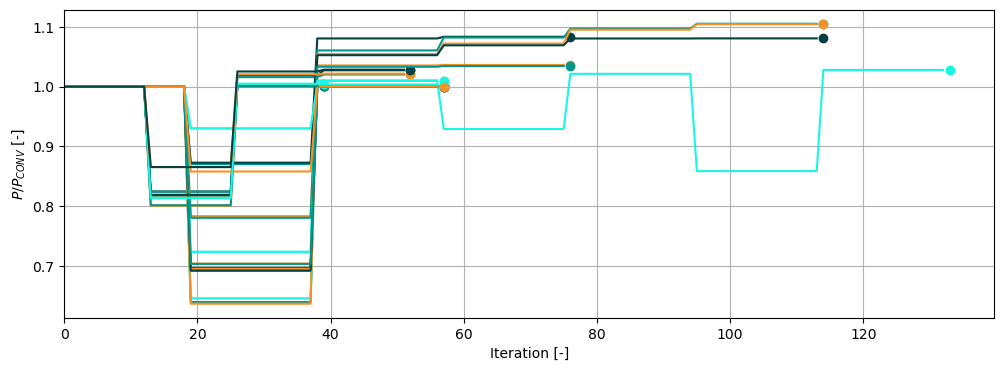

In [138]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
for i in range(len(df_optimization)):
    values = df_optimization['function_values'].iloc[i] / df_optimization['function_values'].iloc[i][0]
    ax.plot(values, color=colors[i%len(colors)])
    ax.scatter(len(values), values[-1], color=colors[i%len(colors)])
ax.set_xlabel('Iteration [-]')
ax.set_ylabel('$P/P_{CONV}$ [-]')
ax.grid()
ax.set_xlim(0,)
plt.show()

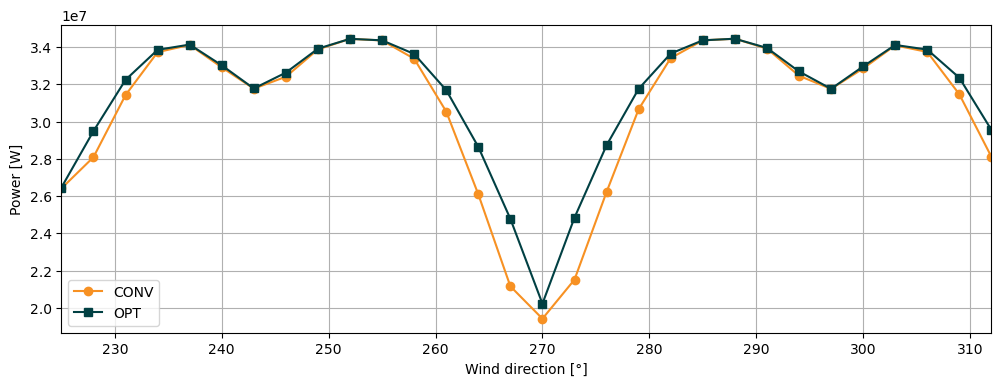

In [148]:
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_optimization['wind_direction'], df_optimization['total_power_conv'], color=colors[0], label='CONV', marker='o')
ax.plot(df_optimization['wind_direction'], df_optimization['total_power'], color=colors[1], label='OPT', marker='s')
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel('Power [W]')
ax.grid()
ax.legend()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()

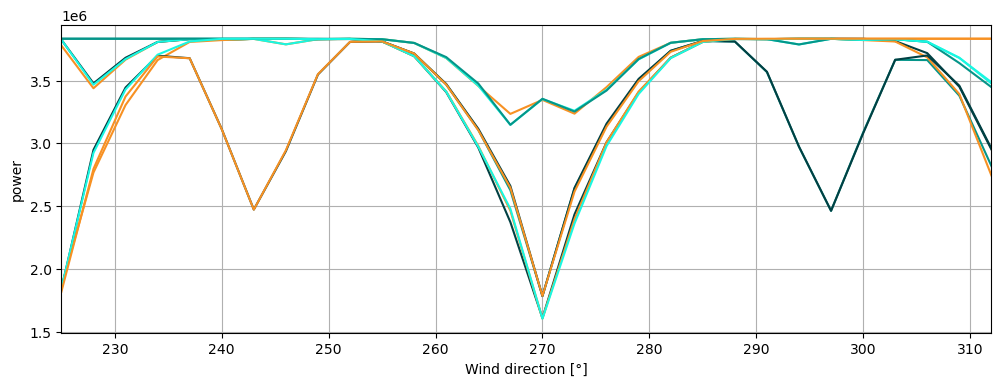

In [144]:
value = 'power'

fig = plt.figure()
fig.set_size_inches(12, 4)
ax = fig.add_subplot(1, 1, 1)
for turb in range(n_turbines):
    ax.plot(df_optimization['wind_direction'], df_optimization[f'{value}_{turb}'], color=colors[turb%len(colors)])
ax.set_xlabel('Wind direction [°]')
ax.set_ylabel(f'{value}')
ax.grid()
ax.set_xlim(min(df_optimization['wind_direction']), max(df_optimization['wind_direction']))
plt.show()